In [1]:
import os
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt
import pymatching
from types_cfg import *
from circuit_generators import *
from sampling_functions import *
from circuit_partition import *
from utilities_tf import *
from CNNModel import *


# Number of worker nodes
n_worker_nodes = 8

# Surface code specifications
d = 5
r = 3
kernel_size = 3

# Data types
binary_t, time_t, idx_t, packed_t = get_types(d, r, kernel_size)

# Error probabilities
p = 0.01
before_round_data_depolarization = p
after_reset_flip_probability = p
after_clifford_depolarization = p
before_measure_flip_probability = p

use_rotated_z = True
observable_type = "ZL" if use_rotated_z else "XL"

# Call signatures for functions that require types
call_group_det_bits_kxk = lambda det_bits_dxd, data_bits_dxd=None, d=d, r=r, k=kernel_size, use_rotated_z=use_rotated_z, binary_t=binary_t, idx_t=idx_t, make_translation_map=False: group_det_bits_kxk(det_bits_dxd, d, r, k, use_rotated_z, data_bits_dxd, binary_t, idx_t, make_translation_map)
call_split_measurements = lambda measurements, d=d, idx_t=idx_t: split_measurements(measurements, d, idx_t)

Configure, check for any saved data, and make it if needed.

In [2]:
n_test = 5000000
n_train = 5000000
stim_sampler_seed = 12345
rnd_seed = 12345
n_samples = n_test + n_train

config_name = f"surface_code_d{d}_r{r}_k{kernel_size}_rRCNN"
saved_data_dir = f"saved_data/{config_name}/obs_{observable_type}_prob_{str(p).replace('.','p')}"
saved_data_dir = f"{saved_data_dir}_N_{n_samples}_seed_{stim_sampler_seed}"
has_saved_data = os.path.exists(saved_data_dir)
os.makedirs(saved_data_dir, exist_ok=True)

decoders = ['pymatching']
test_circuit = get_builtin_circuit(
  "surface_code:rotated_memory_"+('z' if use_rotated_z else 'x'),
  distance=d,
  rounds=r,
  before_round_data_depolarization = before_round_data_depolarization,
  after_reset_flip_probability = after_reset_flip_probability,
  after_clifford_depolarization = after_clifford_depolarization,
  before_measure_flip_probability = before_measure_flip_probability
)
kernel_circuit = get_builtin_circuit(
  "surface_code:rotated_memory_"+('z' if use_rotated_z else 'x'),
  distance=kernel_size,
  rounds=r,
  before_round_data_depolarization = before_round_data_depolarization,
  after_reset_flip_probability = after_reset_flip_probability,
  after_clifford_depolarization = after_clifford_depolarization,
  before_measure_flip_probability = before_measure_flip_probability
)
projerr_circuit = CircuitWithProjectiveErrors(d, r, test_circuit, seed = stim_sampler_seed)
detector_error_model = test_circuit.detector_error_model(decompose_errors=True)

if not has_saved_data:
  measurements, det_evts, flips = projerr_circuit.sample(n_samples, binary_t = binary_t)

  np.save(f"{saved_data_dir}/measurements.npy", measurements)
  np.save(f"{saved_data_dir}/det_evts.npy", det_evts)
  np.save(f"{saved_data_dir}/flips.npy", flips)
else:
  measurements = np.load(f"{saved_data_dir}/measurements.npy")
  det_evts = np.load(f"{saved_data_dir}/det_evts.npy")
  flips = np.load(f"{saved_data_dir}/flips.npy")

Average flip rate for the full circuit: 0.2801778018474579


In [7]:
avg_flips = np.mean(flips, axis=0, dtype=np.float32)
print(f"Average flip rate for the full circuit: {avg_flips}")

Average flip rate for the full circuit: [0.1324763 0.2010514 0.25685   0.2801778]


In [3]:
det_bits, _, _ = call_split_measurements(measurements)

In [8]:
# Make sure the data type is np.int32 below, not idx_t!
idxs_test, idxs_train = split_data(np.arange(n_samples, dtype=np.int32), test_size = n_test/n_samples, seed = rnd_seed, shuffle = False)

class_bits = flips[:, 1:]
features_det_bits = det_bits
features_det_evts = det_evts

print(class_bits.shape)
print(features_det_bits.shape)
print(features_det_evts.shape)

(10000000, 3)
(10000000, 72)
(10000000, 72)


In [5]:
def learning_rate_scheduler(epoch, lr):
  if epoch < 10:
    return 0.001*(10-epoch)
  elif epoch < 20:
    return lr * 0.9
  elif epoch < 30:
    return lr * 0.8
  else:
    return lr * 0.65

In [9]:
n_nodes = 100
model_dxd = FullRCNNModel(
  observable_type, d, kernel_size, r,
  [n_nodes for _ in range(2)],
  npol=2,
  stop_round = None,
  has_nonuniform_response = False,
  do_all_data_qubits = False,
  return_all_rounds = True
)
model_dxd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_dxd([ features_det_bits[0:1], features_det_evts[0:1] ])
model_dxd.summary()


Number of unique contributions: 13
Total number of fractions: 28
Total number of phases: 62
Number of unique contributions: 13
Total number of fractions: 28
Total number of phases: 62
Number of unique contributions: 13
Total number of fractions: 28
Total number of phases: 62

tf.Tensor([[0.5184994 0.5184994 0.5184994]], shape=(1, 3), dtype=float32)
Model: "full_rcnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rcnn_initial_state_kernel_  multiple                  8848      
 combiner (RCNNInitialState                                      
 KernelCombiner)                                                 
                                                                 
 rcnn_lead_in_kernel_combin  multiple                  11091     
 er (RCNNLeadInKernelCombin                                      
 er)                                                             
                             

In [9]:
val_split = 0.2
n_epochs = 50
history = model_dxd.fit(
  x=[ features_det_bits[idxs_train], features_det_evts[idxs_train] ],
  y=class_bits[idxs_train,:],
  batch_size=10000,
  epochs=n_epochs, validation_split=val_split,
  callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)
  ]
)

flips_pred = model_dxd.predict(
  [ features_det_bits[idxs_test], features_det_evts[idxs_test] ],
  batch_size=10000
)
print(f"Inaccuracy of the final model on the test data: {(flips[idxs_test,-1:]!=(flips_pred>0.5).astype(binary_t)).astype(binary_t).sum()/idxs_test.shape[0]}")

Epoch 1/50


2024-06-29 21:54:46.987196: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fd9244d5ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-29 21:54:46.987264: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 4g.40gb, Compute Capability 8.0
2024-06-29 21:54:46.991110: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-29 21:54:47.097093: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 [==============================] - 197s 263ms/step - loss: 0.3183 - accuracy: 0.8484 - val_loss: 0.2012 - val_accuracy: 0.9140 - lr: 0.0100
Epoch 2/50
400/400 [==============================] - 88s 220ms/step - loss: 0.1797 - accuracy: 0.9243 - val_loss: 0.1602 - val_accuracy: 0.9340 - lr: 0.0090
Epoch 3/50
400/400 [==============================] - 89s 221ms/step - loss: 0.1606 - accuracy: 0.9339 - val_loss: 0.1525 - val_accuracy: 0.9377 - lr: 0.0080
Epoch 4/50
400/400 [==============================] - 86s 215ms/step - loss: 0.1488 - accuracy: 0.9395 - val_loss: 0.1456 - val_accuracy: 0.9408 - lr: 0.0070
Epoch 5/50
400/400 [==============================] - 89s 223ms/step - loss: 0.1450 - accuracy: 0.9413 - val_loss: 0.1432 - val_accuracy: 0.9421 - lr: 0.0060
Epoch 6/50
400/400 [==============================] - 86s 214ms/step - loss: 0.1409 - accuracy: 0.9433 - val_loss: 0.1398 - val_accuracy: 0.9439 - lr: 0.0050
Epoch 7/50
400/400 [==============================] - 89s 223m

In [10]:
pymatcher = pymatching.Matching.from_detector_error_model(detector_error_model)
flips_pred_pym = pymatcher.decode_batch(det_evts, bit_packed_predictions=False, bit_packed_shots=False).astype(binary_t).reshape(-1,1)
print(f"PyMatching error rate for the full data set: {np.sum((flips_pred_pym!=flips[:,-1:]))/flips_pred_pym.shape[0]}")
flips_pred_pym = pymatcher.decode_batch(det_evts[idxs_test,:], bit_packed_predictions=False, bit_packed_shots=False).astype(binary_t).reshape(-1,1)
print(f"PyMatching error rate for test data set: {np.sum((flips_pred_pym!=flips[idxs_test,-1:]))/flips_pred_pym.shape[0]}")

PyMatching error rate for the full data set: 0.0494649
PyMatching error rate for test data set: 0.0494946


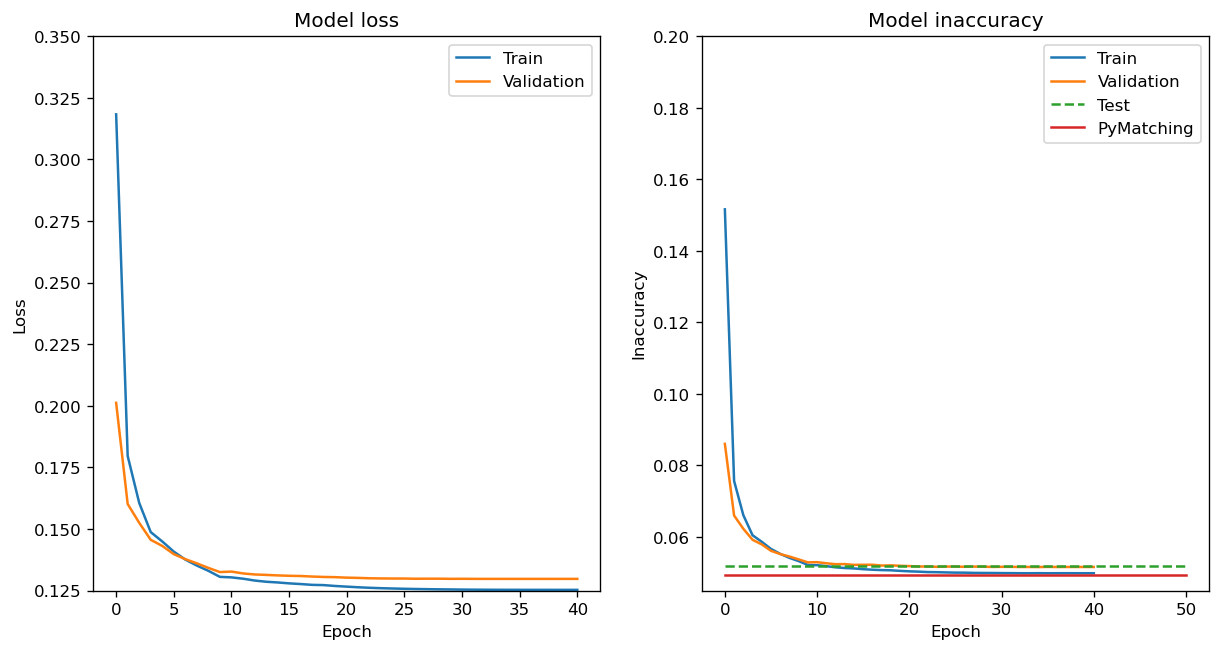

In [11]:
# Plot the training history
# Left panel: loss, right panel: accuracy

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(history.history['loss'], label='Train')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].set_title('Model loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim([0.125, 0.35])
ax[0].legend()

frate = np.sum((flips_pred_pym!=flips[idxs_test,-1:]))/flips_pred_pym.shape[0]
ftest = (flips[idxs_test,-1:]!=(flips_pred>0.5).astype(binary_t)).astype(binary_t).sum()/idxs_test.shape[0]
ax[1].plot([1.-x for x in history.history['accuracy']], label='Train')
ax[1].plot([1.-x for x in history.history['val_accuracy']], label='Validation')
ax[1].plot([0, n_epochs], [ftest]*2, label='Test', linestyle="--")
ax[1].plot([0, n_epochs], [frate]*2, label='PyMatching')
ax[1].set_title('Model inaccuracy')
ax[1].set_ylabel('Inaccuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim([0.045, 0.2])
ax[1].legend()

fig.set_dpi(120)
plt.show()

In [12]:
model_dxd.save_weights(f"{saved_data_dir}/model_dxd", overwrite=True)